# Full Analysis for one Gridcell

In this notebook, all variables for a given grid cell are plotted that are relevant to the robust optimization.

At the end, the optimization is done for the given grid cell.

In [51]:
# For Figure 2
default_lon, default_lat = 13.75, 55.75
# For Figure 8
default_lon, default_lat = 23.75, 61.75
# default_lon, default_lat = 9.75, 49.75
# default_lon, default_lat = 21.75, 39.75

In [52]:
import importlib
from compute_entropy import *
import analyze_lpj_output as analysis
import matplotlib.pyplot as plt
import optimization as opt
from surface_roughness import *
from matplotlib import gridspec
import optimization_preparation as oprep
import optimization_plots as oplot
from constants import *
import surface_roughness as sr
import helper.chunk_filter as cf
import optimize_gridcell as og
import pandas_helper as ph

run_dir = 'lpjguess_output_subset/'

rcp26_simulations = dict(
    base=run_dir + 'base_rcp26/',
    toBd=run_dir + 'tobd_rcp26/',
    toBe=run_dir + 'tobe_rcp26/',
    toCoppice=run_dir + 'toCoppice_rcp26/',
    toNe=run_dir + 'tone_rcp26/',
    unmanaged=run_dir + 'unmanaged_rcp26/',
)

rcp45_simulations = dict(
    base=run_dir + 'base_rcp45/',
    toBd=run_dir + 'tobd_rcp45/',
    toBe=run_dir + 'tobe_rcp45/',
    toCoppice=run_dir + 'toCoppice_rcp45/',
    toNe=run_dir + 'tone_rcp45/',
    unmanaged=run_dir + 'unmanaged_rcp45/',
)

rcp60_simulations = dict(
    base=run_dir + 'base_rcp60/',
    toBd=run_dir + 'tobd_rcp60/',
    toBe=run_dir + 'tobe_rcp60/',
    toCoppice=run_dir + 'toCoppice_rcp60/',
    toNe=run_dir + 'tone_rcp60/',
    unmanaged=run_dir + 'unmanaged_rcp60/',
)

rcp85_simulations = dict(
    base=run_dir + 'base_rcp85/',
    toBd=run_dir + 'tobd_rcp85/',
    toBe=run_dir + 'tobe_rcp85/',
    toCoppice=run_dir + 'toCoppice_rcp85/',
    toNe=run_dir + 'tone_rcp85/',
    unmanaged=run_dir + 'unmanaged_rcp85/',
)

simulations = {'rcp26': rcp26_simulations, 'rcp45': rcp45_simulations, 'rcp60': rcp60_simulations,
               'rcp85': rcp85_simulations}

used_simulations = ['toBd', 'toBe', 'toCoppice', 'toNe', 'base', 'unmanaged']
boundary_simulations = []
rcpppp = ['rcp26', 'rcp45', 'rcp60', 'rcp85']
n_rcp = len(rcpppp)

# Climate

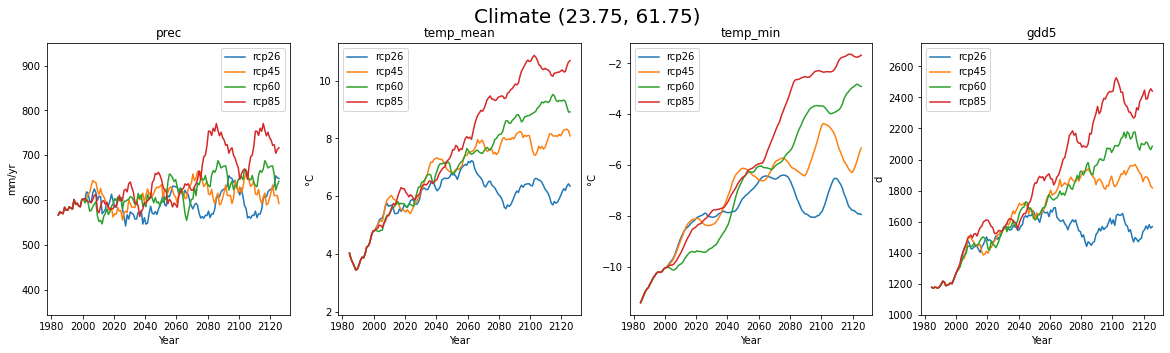

In [53]:
var_units = dict(prec='mm/yr', temp_mean='°C', temp_min='°C', gdd5='d')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx, (variable, unit) in enumerate(var_units.items()):

    min_y=float('inf')
    max_y=float('-inf')

    for rcp in simulations.keys():
        climate = ph.read_for_gridcell(simulations[rcp]['base'] + 'seasonality.out', default_lon, default_lat)

        max_val = climate[variable].max()
        min_val = climate[variable].min()

        if min_val < min_y:
            min_y = min_val
        if max_val > max_y:
            max_y = max_val

        climate.rolling(10).mean().plot(x='Year', y=variable, label=rcp, ax=ax[idx])

    ax[idx].set_ylabel(unit)
    ax[idx].set_title(variable)
    ax[idx].set_ylim([min_y, max_y])

fig.suptitle('Climate (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Forest Structure

## Foliar Projective Cover

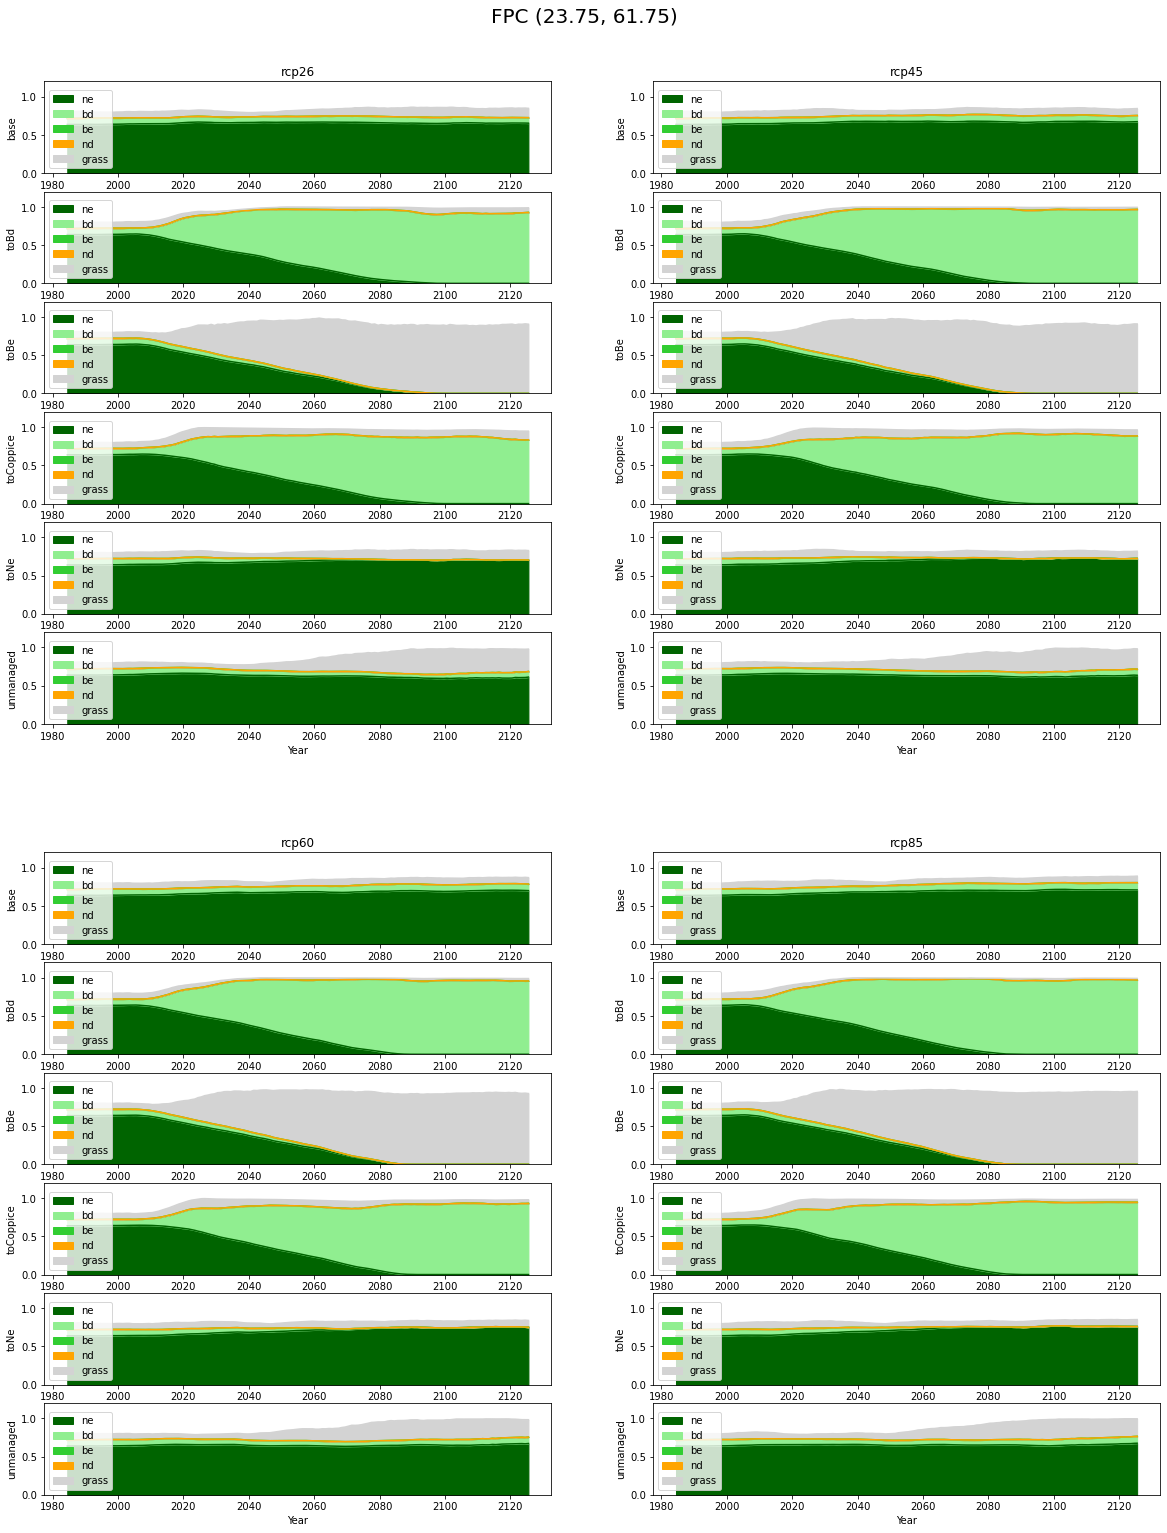

In [54]:
fig = plt.figure(figsize=(20, 26))
fig.tight_layout()
grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

for idx_rcp, rcp in enumerate(simulations.keys()):
    
    n_strategies = len(simulations[rcp])
    gs00 = gridspec.GridSpecFromSubplotSpec(n_strategies, 1, subplot_spec=grid[idx_rcp])
    
    idx_strategy=0
    for idx_strategy, (simulation, basepath) in enumerate(simulations[rcp].items()):
        ax1 = plt.subplot(gs00[idx_strategy, 0])
        
        fpc_forest = oprep.get_fpc(basepath, lons_lats_of_interest=[(default_lon, default_lat)], min_year=1950, max_year=2130, fpc_type='lai')
        fpc_forest.reset_index().rolling(10).mean().plot(x='Year', y=['ne', 'bd', 'be', 'nd', 'grass'], ax=ax1, stacked=True, kind='area', color=['darkgreen', 'lightgreen', 'limegreen', 'orange', 'lightgrey'])
        
        if(idx_strategy == 0):
            ax1.set_title(rcp)
        ax1.set_ylim([0, 1.2])
        ax1.set_ylabel(simulation)
        ax1.legend(loc=3)
        
        idx_strategy+=1

fig.suptitle('FPC (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20,  y=0.92);

## Forest Conversion

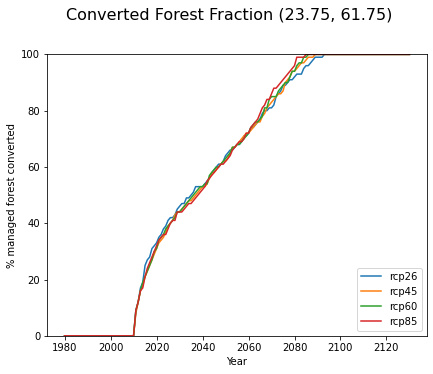

In [55]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,4.5))
fig.tight_layout()

for idx_rcp, rcp in enumerate(simulations.keys()):
    conversion = ph.read_for_gridcell(simulations[rcp]['base'] + 'converted_fraction.out', default_lon, default_lat)
    conversion['Fraction']*=100
    conversion.reset_index().plot(x='Year', y='Fraction', ax=ax1, label=rcp)
    
ax1.set_ylim([0, 100])
ax1.set_ylabel('% managed forest converted')
ax1.legend(loc='lower right')

fig.suptitle('Converted Forest Fraction (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=16, y=1.1);

# Carbon Sequestration

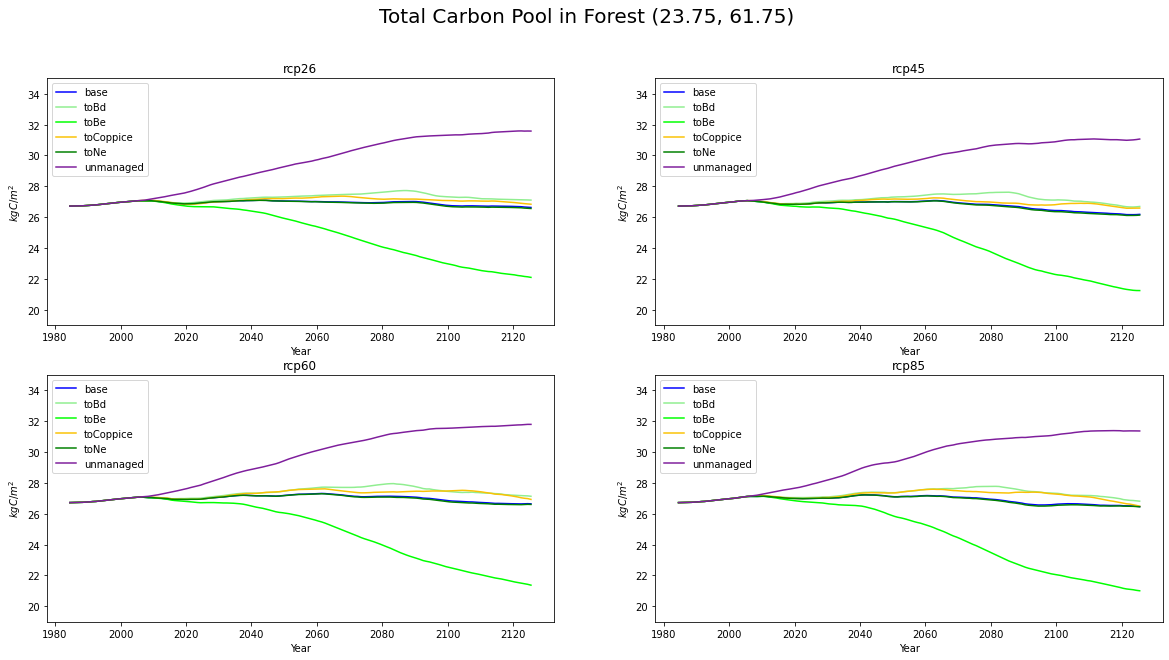

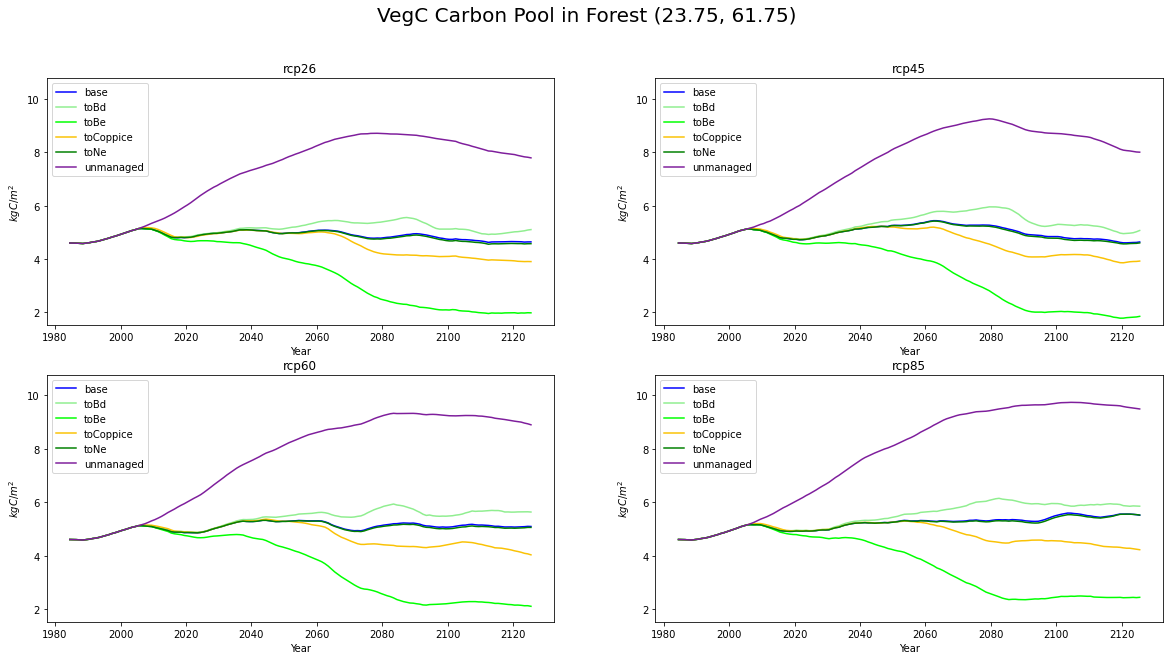

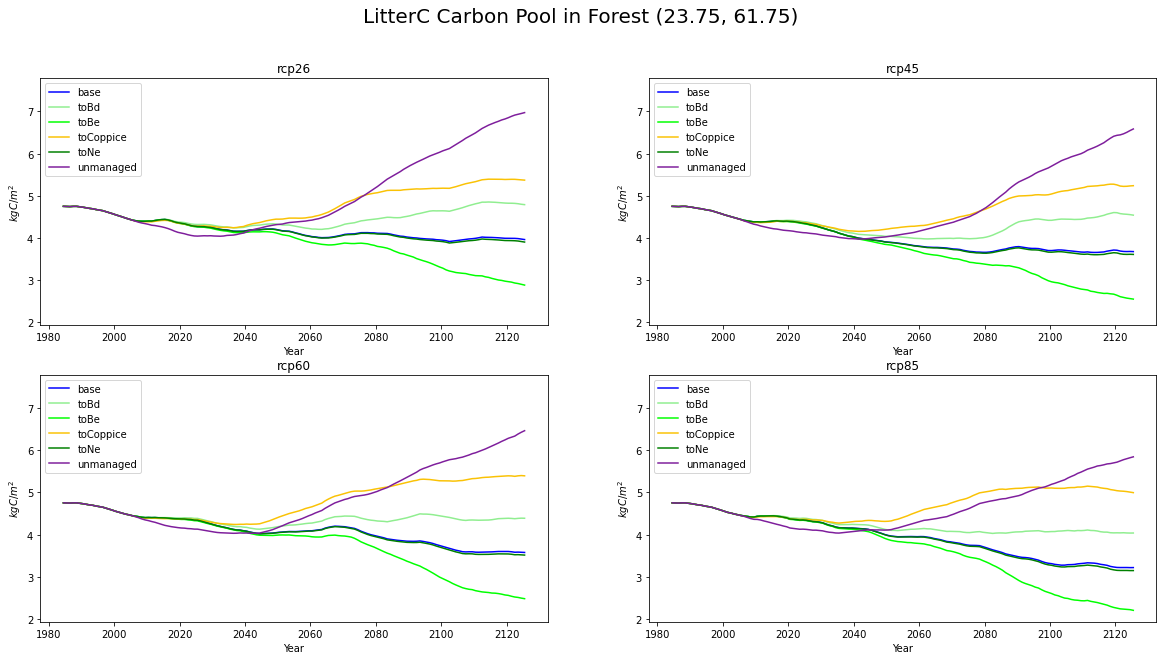

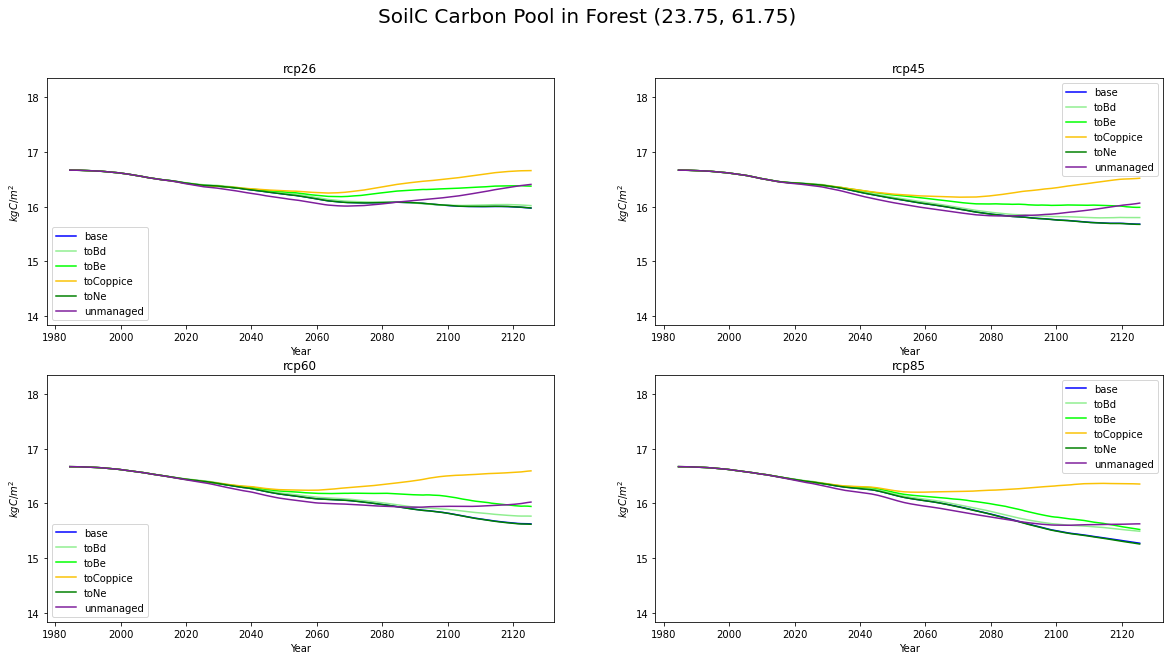

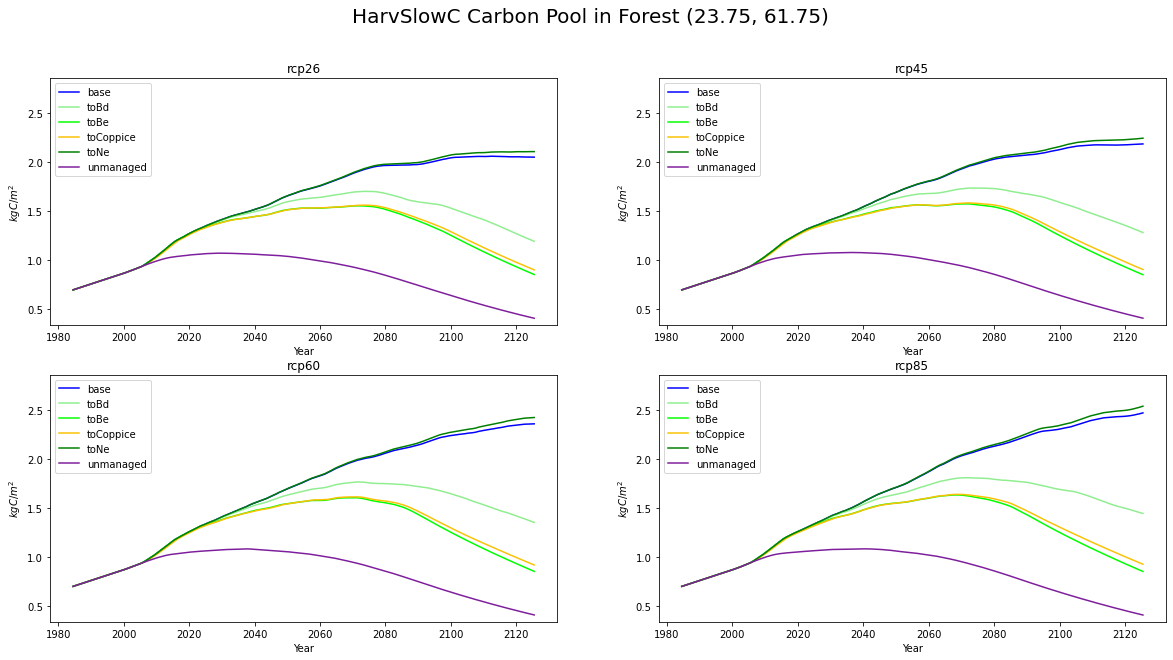

In [56]:
for pool in ['Total', 'VegC', 'LitterC', 'SoilC', 'HarvSlowC']:

    fig, axs = plt.subplots(2,2, figsize=(20, 10))

    max_y=0
    min_y=float('inf')
    for idx, rcp in enumerate(rcpppp):
        for simulation, basepath in simulations[rcp].items():
            iter_csv = pd.read_csv(basepath + 'cpool.out', delim_whitespace=True, iterator=True)
            cpool = pd.concat([chunk[(chunk['Lat'] == default_lat) & (chunk['Lon'] == default_lon)] for chunk in iter_csv])
            cpool.rolling(10).mean().plot(x='Year', y=pool, label=simulation, ax=axs[int(idx/2),idx%2], color=color_discrete_map[simulation])
            
            if cpool[pool].max() > max_y:
                max_y = cpool[pool].max()
                
            if cpool[pool].min() < min_y:
                min_y = cpool[pool].min()
            
        axs[int(idx/2),idx%2].set_title(rcp)
        axs[int(idx/2),idx%2].set_ylabel(r'$kgC/m^2$')
        idx+=1
    for axx in axs:
        for ax in axx:
            ax.set_ylim([min_y/1.1, max_y*1.1])
    fig.suptitle(pool + ' Carbon Pool in Forest (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20)

# Harvests

## Total Harvests

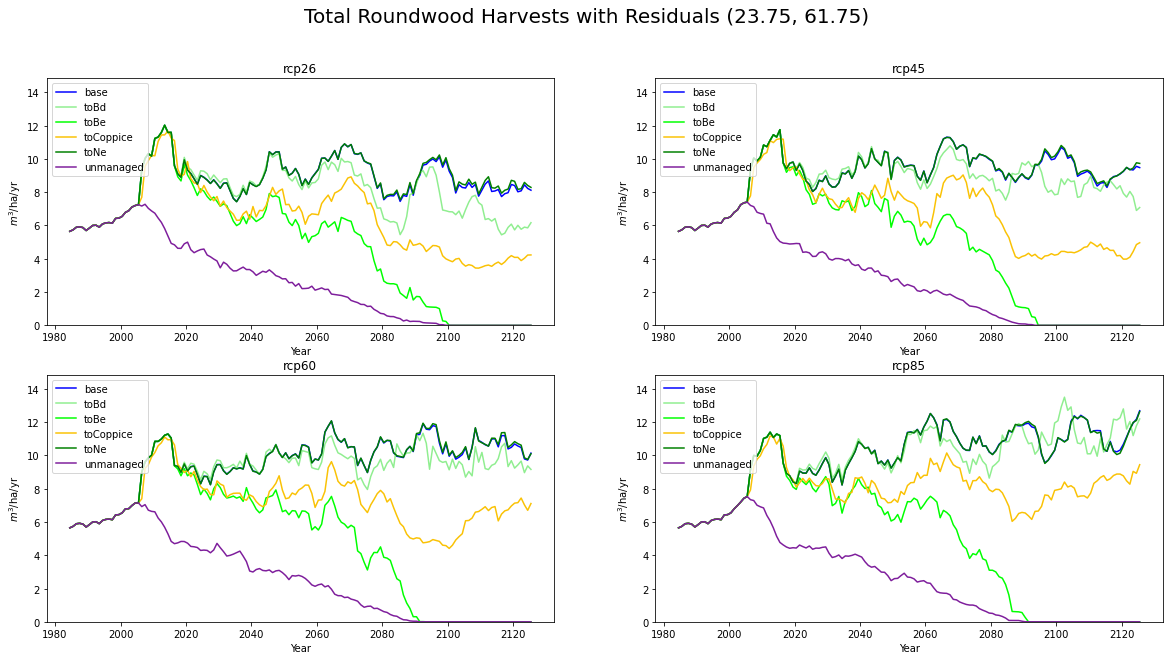

In [57]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

max_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():

        harv = oprep.get_harvests_via_species_file(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)], residuals=True)
        avg_harv = harv.rolling(10).mean()
        max_val = avg_harv['total_harv_m3_wood_per_ha'].max()
        if max_val > max_y:
            max_y = max_val

        avg_harv.plot(x='Year', y='total_harv_m3_wood_per_ha', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('$m^3$/ha/yr')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([0, 1.1*max_y])
        ax.legend(loc=2)

fig.suptitle('Total Roundwood Harvests with Residuals (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

## Harvests for long-lived product pools

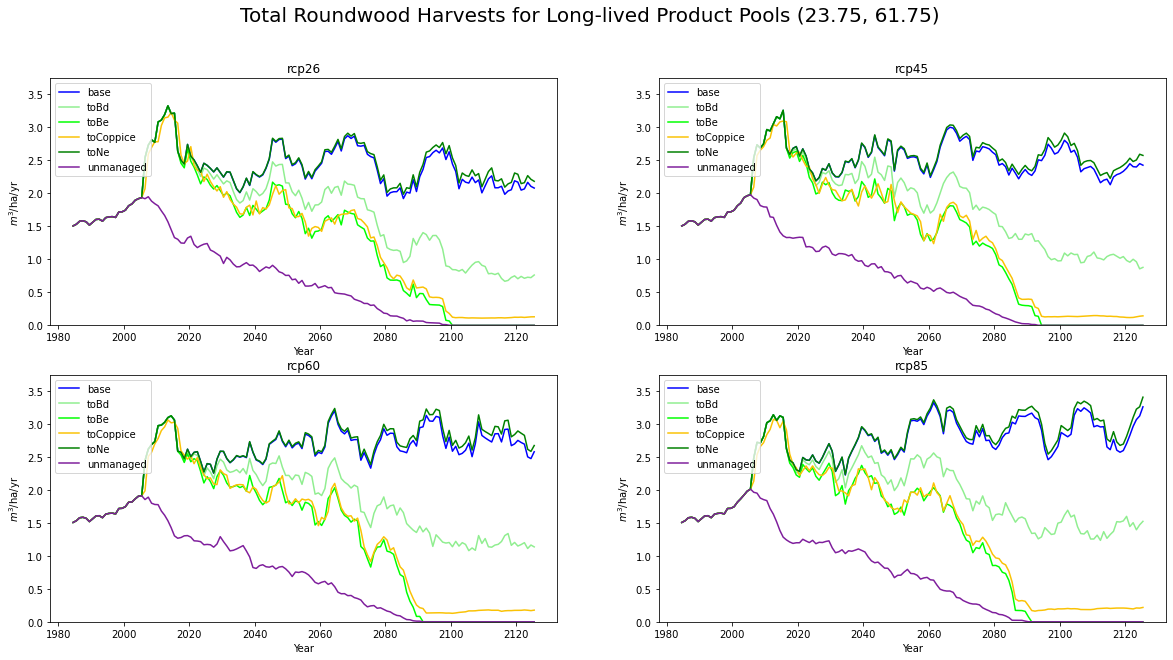

In [58]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

max_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():

        harv = oprep.get_harvests_via_species_file(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)], slow_only=True)
        avg_harv = harv.rolling(10).mean()
        max_val = avg_harv['total_harv_m3_wood_per_ha'].max()
        if max_val > max_y:
            max_y = max_val

        avg_harv.plot(x='Year', y='total_harv_m3_wood_per_ha', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('$m^3$/ha/yr')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([0, 1.1*max_y])
        ax.legend(loc=2)

fig.suptitle('Total Roundwood Harvests for Long-lived Product Pools (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Mitigation

## Without Discounting of Mitigation

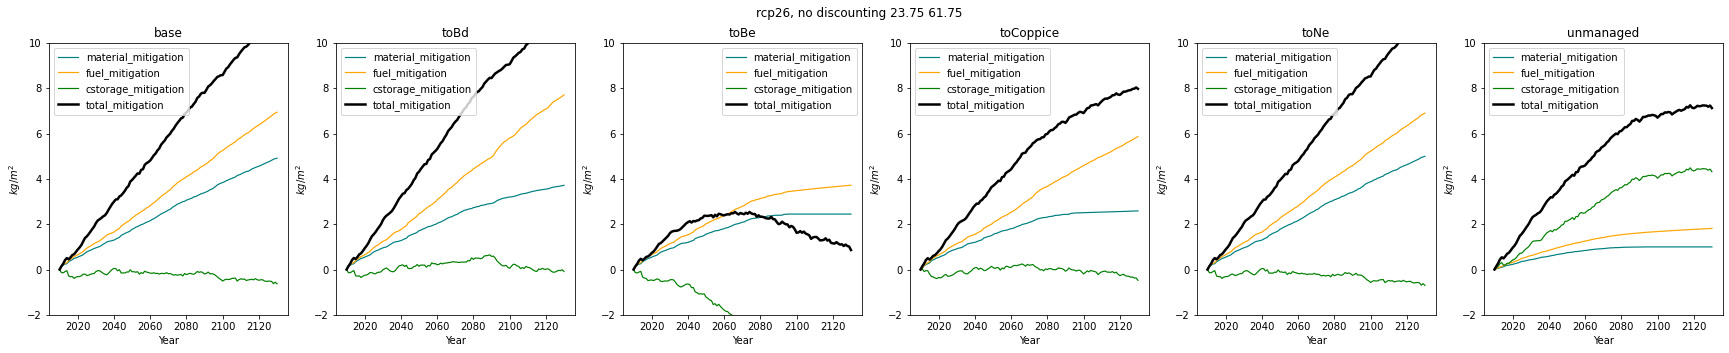

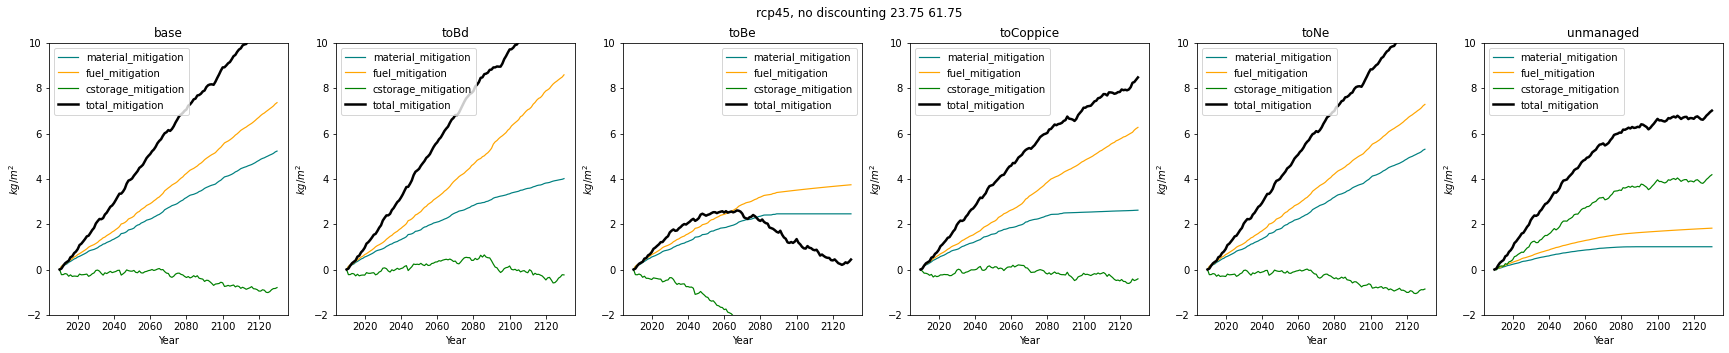

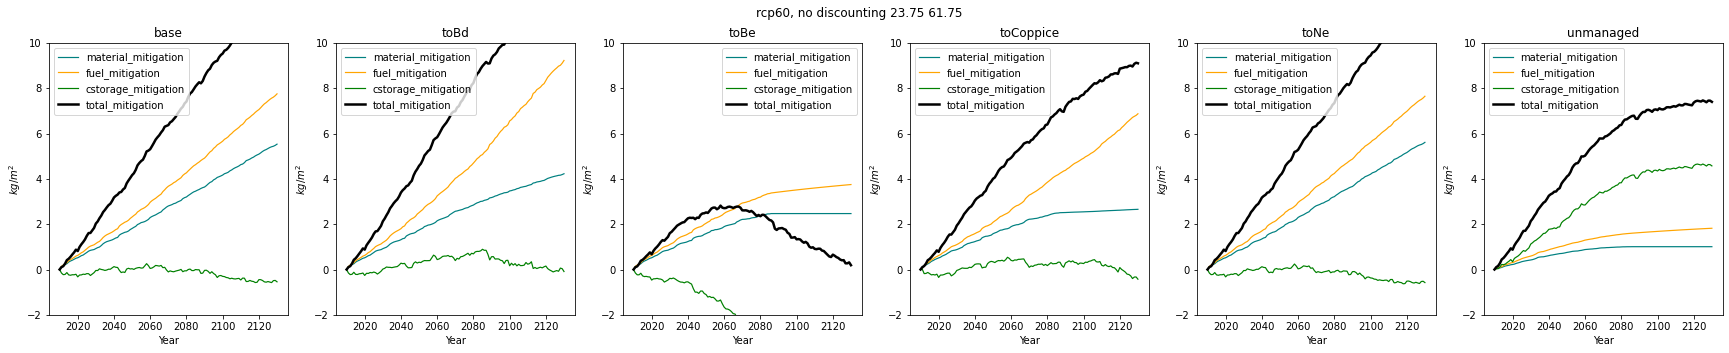

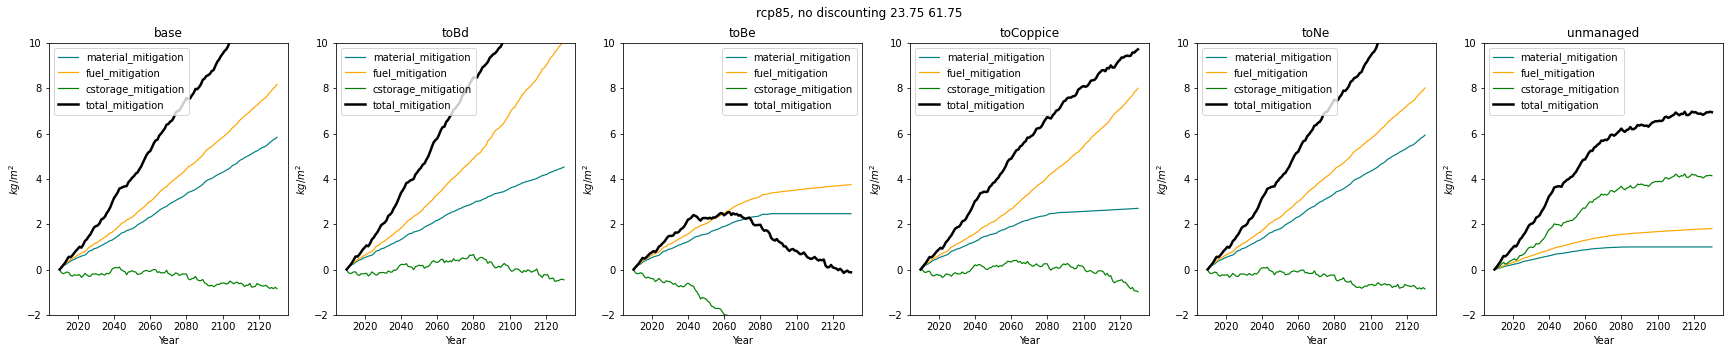

In [59]:
for rcp in rcpppp:
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    for idx, (management, path) in enumerate(simulations[rcp].items()):

        cpool = oprep.get_cpool(path, 2010, 2150, [(default_lon, default_lat)])
        cflux = oprep.get_fluxes_with_new_harvests(path, 2010, 2150, [(default_lon, default_lat)])
        mitigation = oprep.get_new_total_mitigation(cflux, cpool, discounting=None).reset_index()

        for col, style, lw in zip(['material_mitigation', 'fuel_mitigation', 'cstorage_mitigation', 'total_mitigation'], ['teal', 'orange', 'g', 'k'], [1.2, 1.2, 1.2, 2.5]):
            mitigation.plot(x='Year', y=col, ax=axs[idx], style=style, lw=lw)
        axs[idx].set_title(management)
        axs[idx].set_ylabel('$kg/m^2$')
        axs[idx].set_ylim([-2, 10])

    fig.suptitle(rcp + ', no discounting ' + str(default_lon) + ' ' + str(default_lat));

## With Discounting

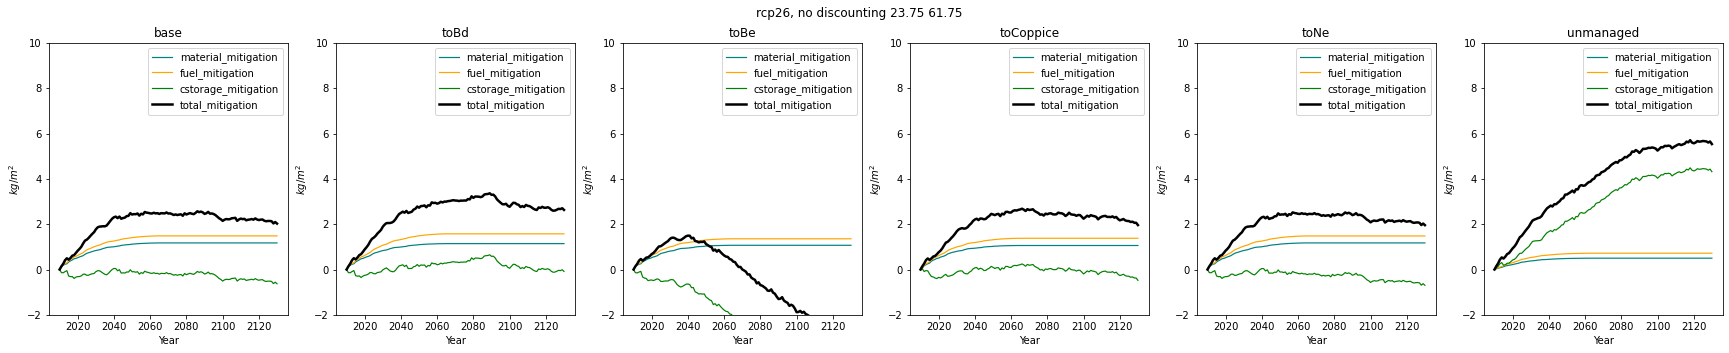

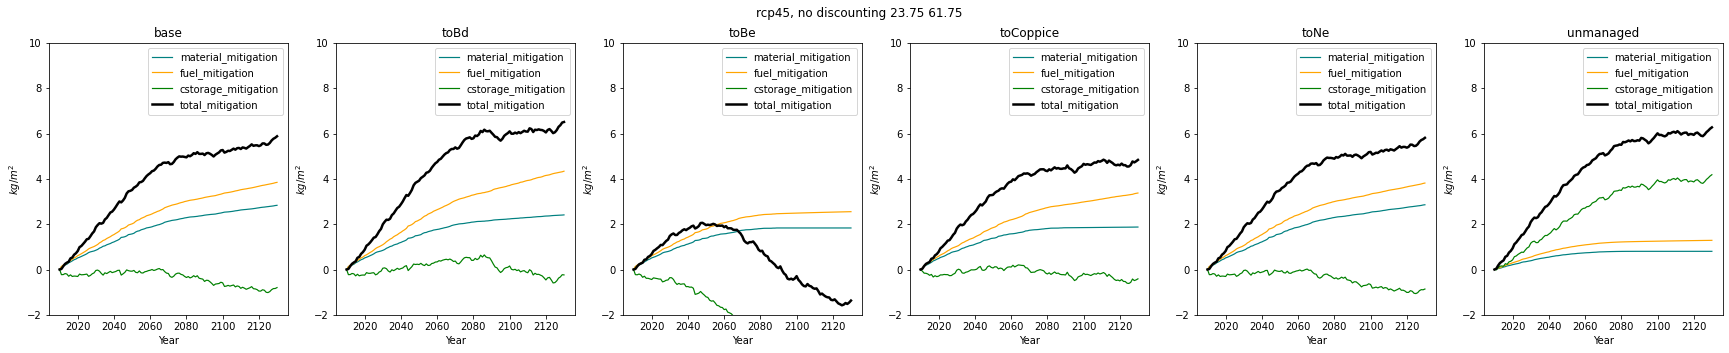

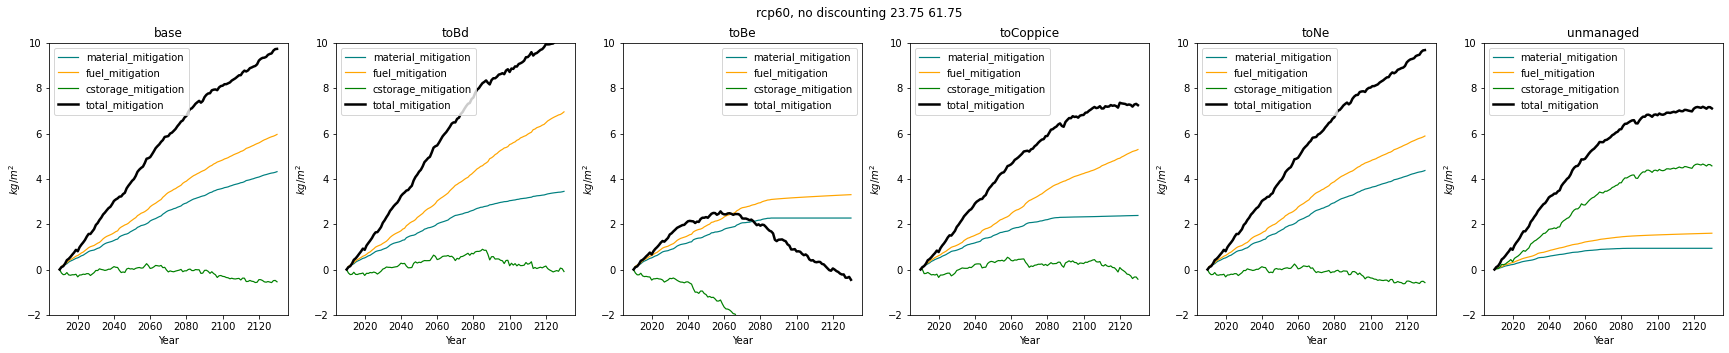

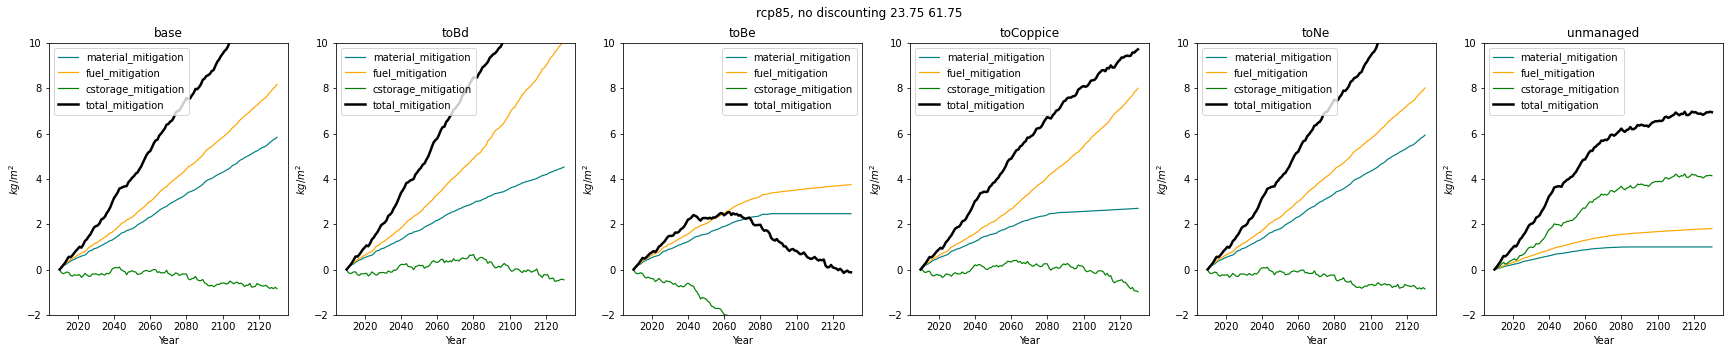

In [60]:
for rcp in rcpppp:
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    for idx, (management, path) in enumerate(simulations[rcp].items()):

        cpool = oprep.get_cpool(path, 2010, 2150, [(default_lon, default_lat)])
        cflux = oprep.get_fluxes_with_new_harvests(path, 2010, 2150, [(default_lon, default_lat)])
        mitigation = oprep.get_new_total_mitigation(cflux, cpool, discounting=rcp).reset_index()

        for col, style, lw in zip(['material_mitigation', 'fuel_mitigation', 'cstorage_mitigation', 'total_mitigation'], ['teal', 'orange', 'g', 'k'], [1.2, 1.2, 1.2, 2.5]):
            mitigation.plot(x='Year', y=col, ax=axs[idx], style=style, lw=lw)
        axs[idx].set_title(management)
        axs[idx].set_ylabel('$kg/m^2$')
        axs[idx].set_ylim([-2, 10])

    fig.suptitle(rcp + ', no discounting ' + str(default_lon) + ' ' + str(default_lat));

# Biodiversity

## Thick Trees

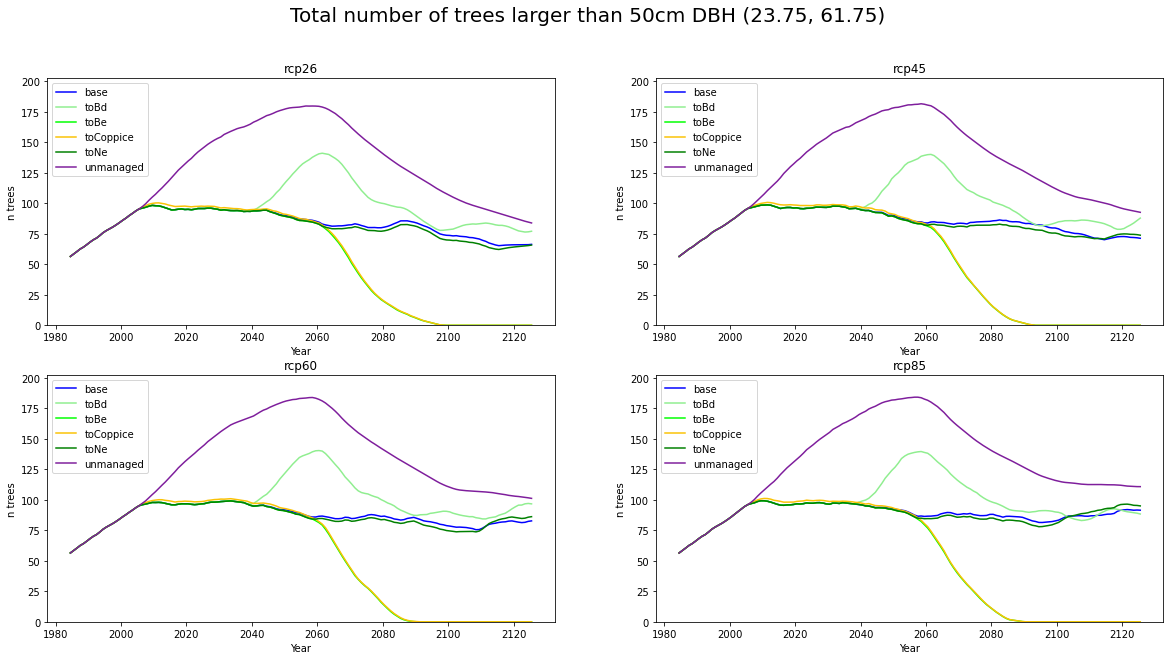

In [61]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

max_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():
        bio_big_trees = oprep.get_biodiversity_tree_sizes(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)])
        avg_bio_big_trees = bio_big_trees.rolling(10).mean()
        max_val = avg_bio_big_trees['thick_trees'].max()
        if max_val > max_y:
            max_y = max_val

        avg_bio_big_trees.plot(x='Year', y='thick_trees', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('n trees')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([0, 1.1*max_y])
        ax.legend(loc=2)

fig.suptitle('Total number of trees larger than 50cm DBH (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

## Size Diversity

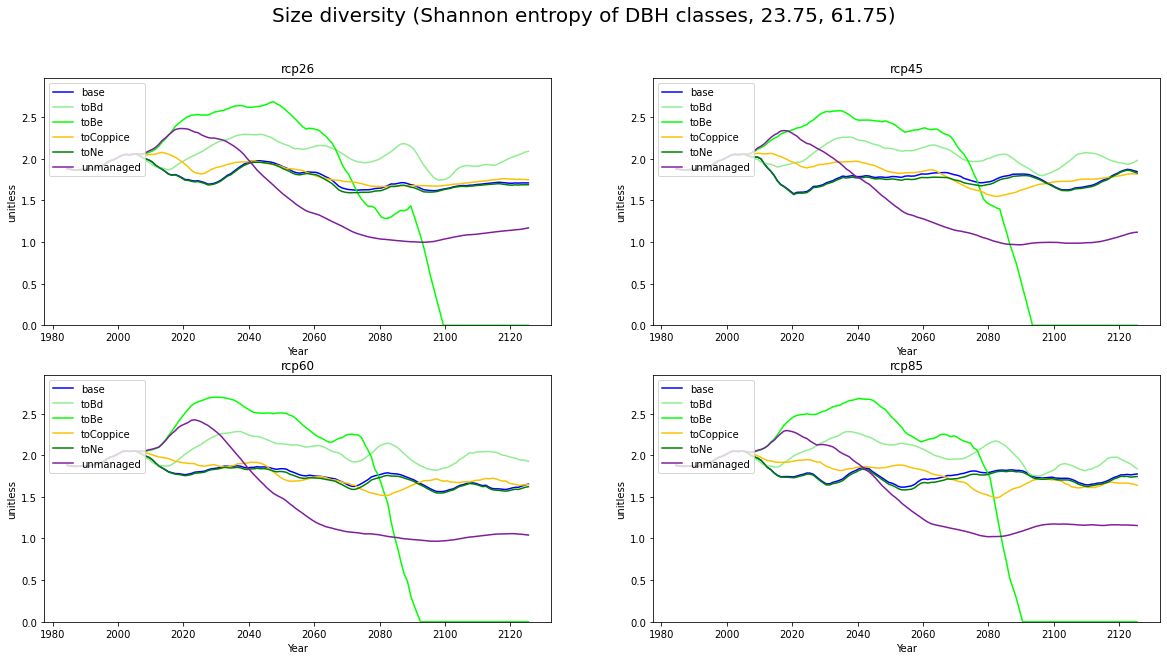

In [62]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

max_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():
        bio_big_trees = oprep.get_biodiversity_tree_sizes(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)])
        avg_bio_big_trees = bio_big_trees.rolling(10).mean()
        max_val = avg_bio_big_trees['size_diversity'].max()
        if max_val > max_y:
            max_y = max_val

        avg_bio_big_trees.plot(x='Year', y='size_diversity', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('unitless')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([0, 1.1*max_y])
        ax.legend(loc=2)

fig.suptitle('Size diversity (Shannon entropy of DBH classes, ' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

## Coarse Woody Debris

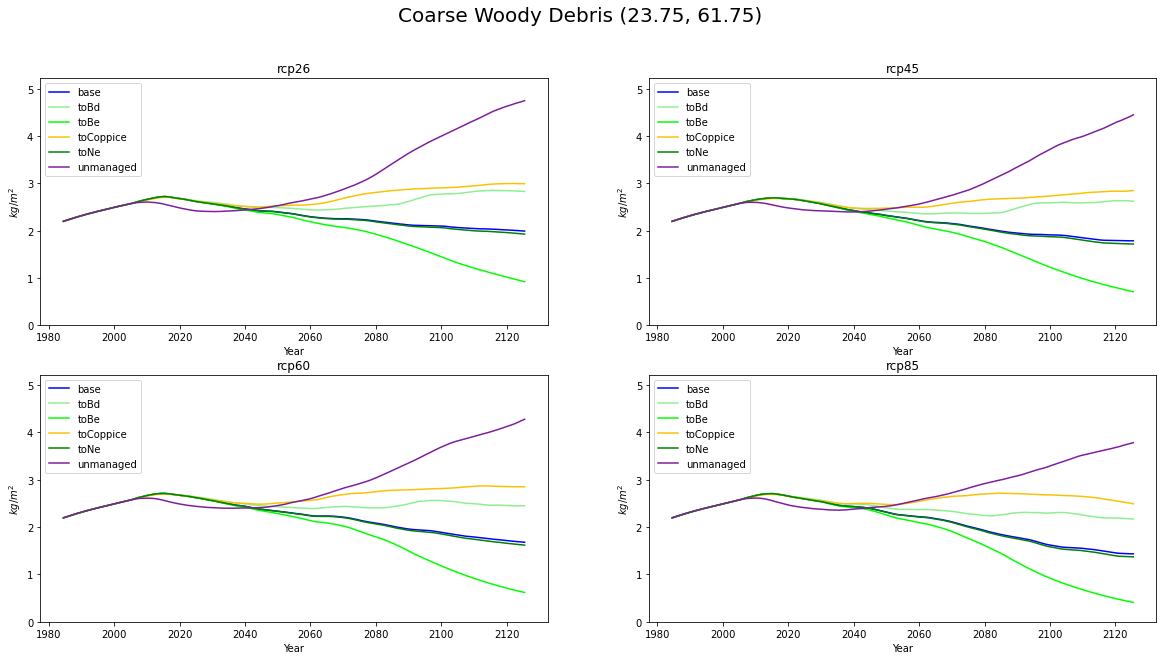

In [63]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

max_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():
        bio_big_trees = oprep.get_biodiversity_cwd(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)])
        avg_bio_big_trees = bio_big_trees.rolling(10).mean()
        max_val = avg_bio_big_trees['ForestCWD'].max()
        if max_val > max_y:
            max_y = max_val

        avg_bio_big_trees.plot(x='Year', y='ForestCWD', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('$kg/m^2$')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([0, 1.1*max_y])
        ax.legend(loc=2)

fig.suptitle('Coarse Woody Debris (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Soil Water Potential

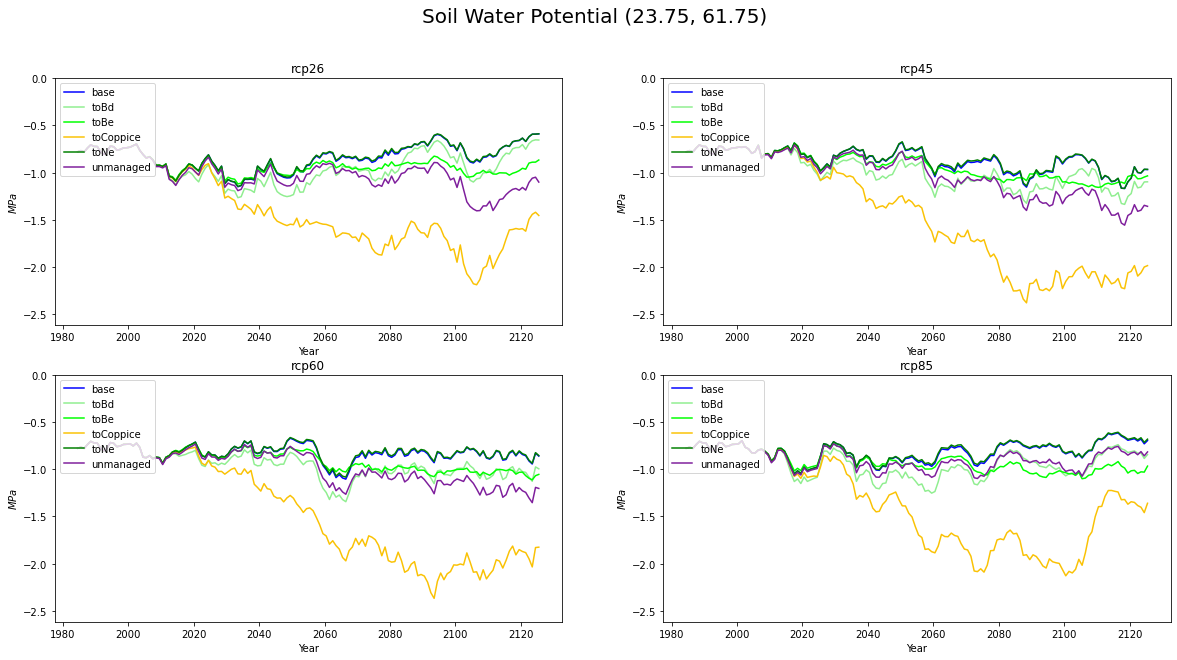

In [64]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

min_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():
        swp = oprep.get_forest_swp(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)])
        avg_swp = swp.rolling(10).mean()
        min_val = avg_swp['min'].min()
        if min_val < min_y:
            min_y = min_val

        avg_swp.plot(x='Year', y='min', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('$MPa$')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([1.1*min_y, 0])
        ax.legend(loc=2)

fig.suptitle('Soil Water Potential (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

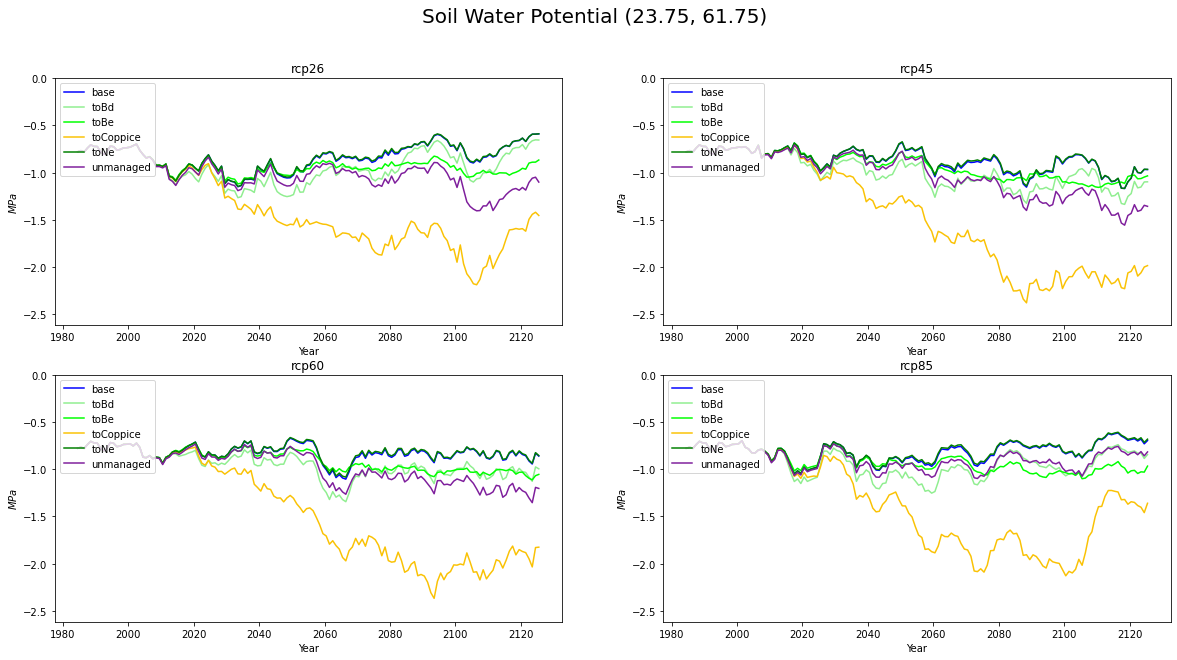

In [65]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

min_y = 0
for idx, rcp in enumerate(rcpppp):
    for management, basepath in simulations[rcp].items():
        swp = oprep.get_forest_swp(basepath, 1800, 2200, lons_lats_of_interest=[(default_lon, default_lat)])
        avg_swp = swp.rolling(10).mean()
        min_val = avg_swp['min'].min()
        if min_val < min_y:
            min_y = min_val

        avg_swp.plot(x='Year', y='min', label=management, ax=axs[int(idx/2),idx%2], color=color_discrete_map[management])
    axs[int(idx/2),idx%2].set_ylabel('$MPa$')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([1.1*min_y, 0])
        ax.legend(loc=2)

fig.suptitle('Soil Water Potential (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Evapotranspiration

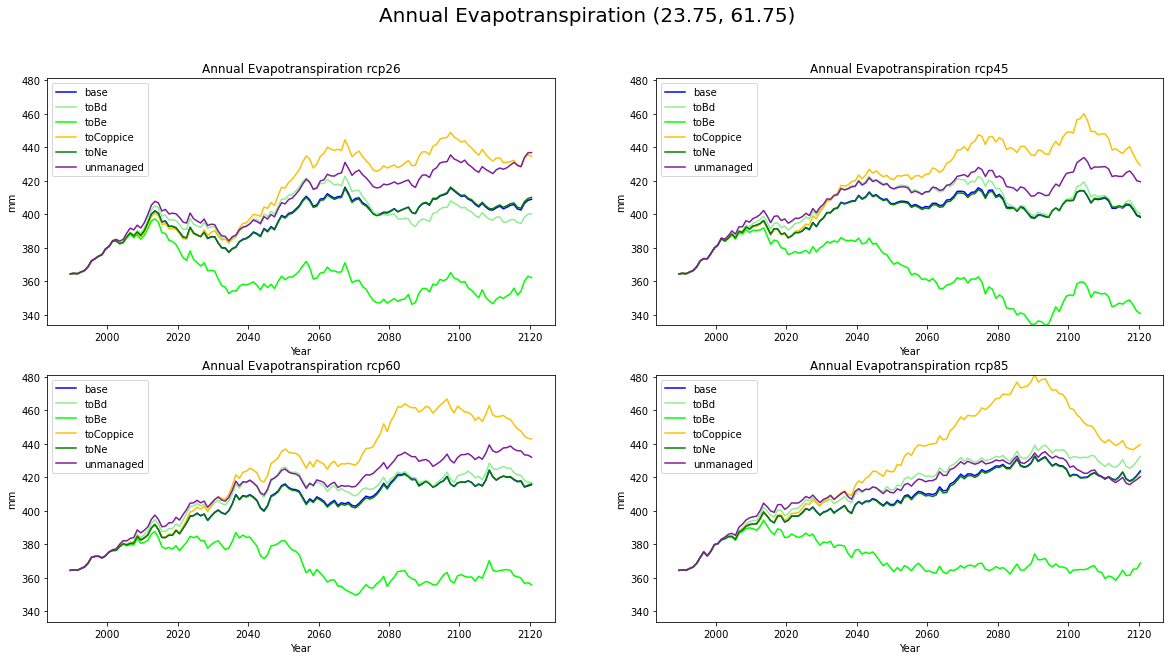

In [66]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

min_y=float('inf')
max_y=float('-inf')

for idx, rcp in enumerate(simulations.keys()):
    for simulation, basepath in simulations[rcp].items():
        aet = oprep.get_forest_et(basepath, 1900, 2150, [(default_lon, default_lat)])
        avg_aet = aet.rolling(20).mean()
        
        max_val = avg_aet['YearlyTotal'].max()
        min_val = avg_aet['YearlyTotal'].min()
        
        if min_val < min_y:
            min_y = min_val
        if max_val > max_y:
            max_y = max_val
            
        avg_aet.plot(x='Year', y='YearlyTotal', label=simulation, ax=axs[int(idx/2),idx%2], color=color_discrete_map[simulation])

    axs[int(idx/2),idx%2].set_ylabel('mm')
    axs[int(idx/2),idx%2].set_title('Annual Evapotranspiration ' + rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([min_y, max_y])
    
fig.suptitle('Annual Evapotranspiration (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Surface Roughness

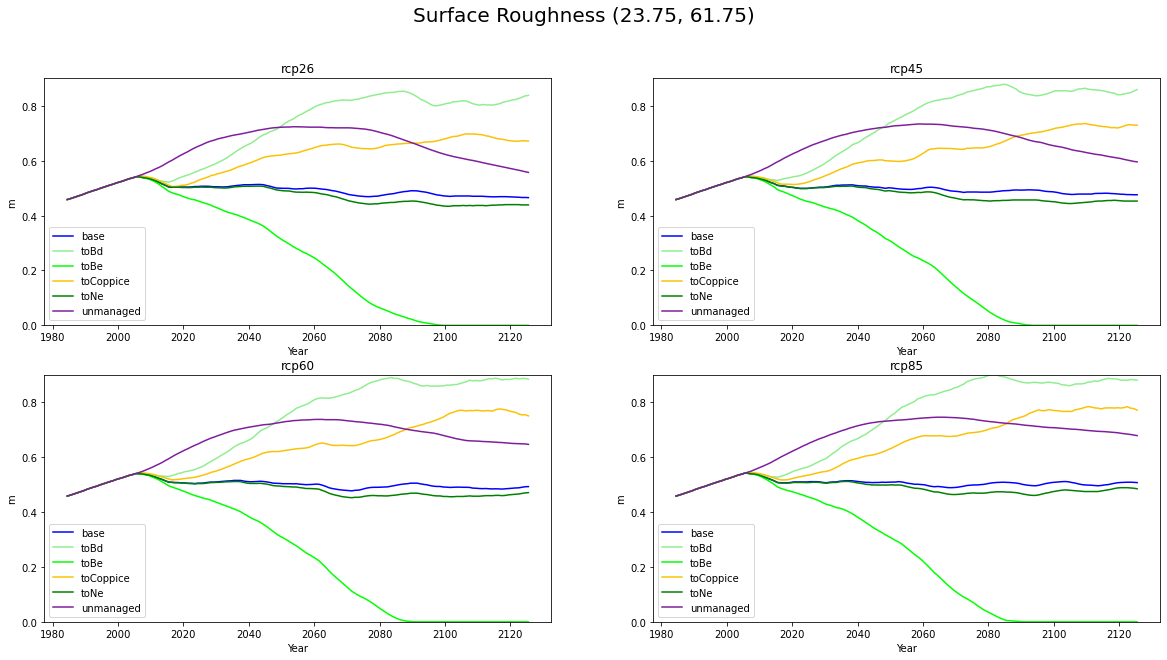

In [67]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))

min_y=float('inf')
max_y=float('-inf')

for idx, rcp in enumerate(simulations.keys()):
    for simulation, basepath in simulations[rcp].items():
        z0 = oprep.get_surface_roughness(basepath, 1900, 2150, [(default_lon, default_lat)])
        avg_z0 = z0.rolling(10).mean()

        max_val = avg_z0['z0'].max()
        min_val = avg_z0['z0'].min()

        if min_val < min_y:
            min_y = min_val
        if max_val > max_y:
            max_y = max_val

        avg_z0.plot(x='Year', y='z0', label=simulation, ax=axs[int(idx/2),idx%2], color=color_discrete_map[simulation])

    axs[int(idx/2),idx%2].set_ylabel('m')
    axs[int(idx/2),idx%2].set_title(rcp)

for axx in axs:
    for ax in axx:
        ax.set_ylim([min_y, max_y])

fig.suptitle('Surface Roughness (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Disturbances

## Accumulated Losses Through Disturbance

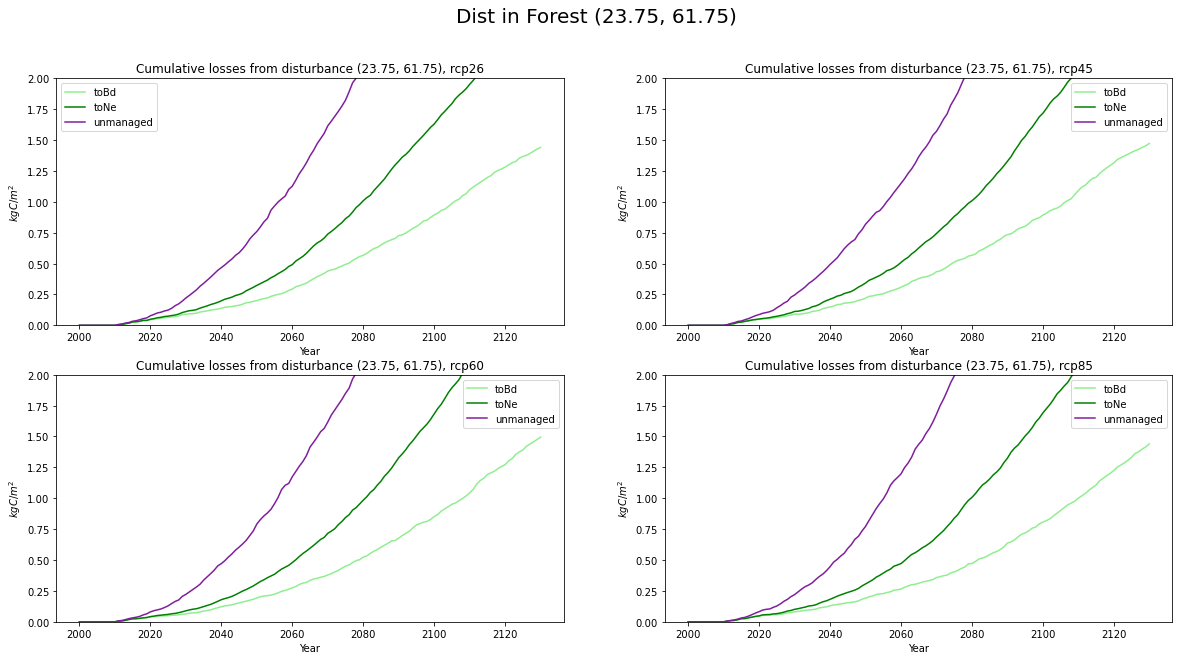

In [68]:
for flux in ['Dist']:

    fig, axs = plt.subplots(2,2, figsize=(20, 10))

    max_y=0
    min_y=float('inf')
    for idx, rcp in enumerate(rcpppp):
        for simulation, basepath in simulations[rcp].items():
            
            if simulation == 'toBe' or simulation == 'toCoppice' or simulation == 'base':
                continue

            fluxes = ph.read_for_years(basepath + 'cflux_forest.out', 2000, 2150, [(default_lon, default_lat)]).set_index(['Lon', 'Lat', 'Year']).cumsum()
            fluxes.reset_index().plot(x='Year', y=flux, label=simulation, ax=axs[int(idx/2),idx%2], color=color_discrete_map[simulation])
            
        axs[int(idx/2),idx%2].set_title('Cumulative losses from disturbance (' + str(default_lon) + ', ' + str(default_lat) + '), ' + rcp)
        axs[int(idx/2),idx%2].set_ylabel(r'$kgC/m^2$')
        axs[int(idx/2),idx%2].set_ylim([0, 2])
    fig.suptitle(flux + ' in Forest (' + str(default_lon) + ', ' + str(default_lat) + ')', fontsize=20);

# Optimization

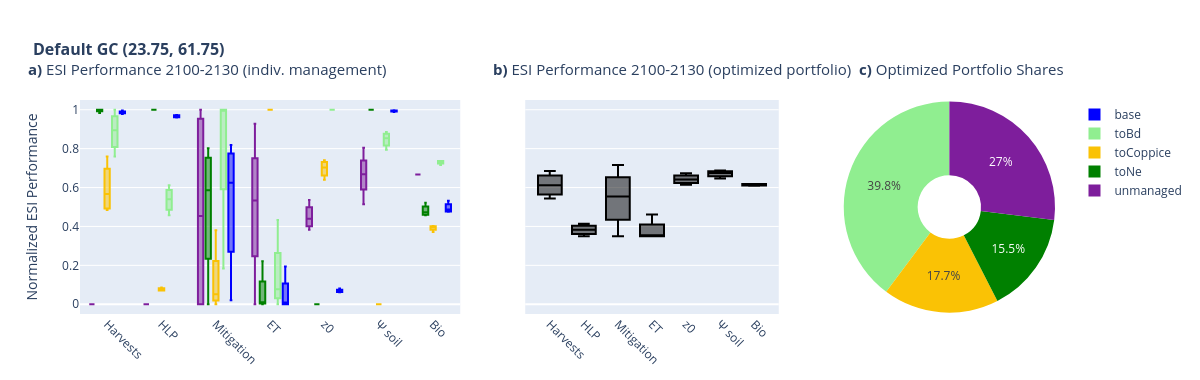

In [69]:
import constants as constants
import optimization_setup as opt_setup
import variable_units as vu
import sys, os
importlib.reload(vu)
importlib.reload(opt_setup)
importlib.reload(constants)
importlib.reload(oplot)
importlib.reload(opt)
importlib.reload(oprep)
importlib.reload(cf)
importlib.reload(og)
importlib.reload(analysis)
importlib.reload(sr)

# necessary to have the graphic both here as well as in an exported PDF.
import plotly.io as pio
pio.renderers.default = "notebook+pdf+png"


sys.stdout = open(os.devnull, 'w')
# sys.stdout = sys.__stdout__ # enable

varrrs =['harvest', 'hlp', 'mitigation', 'et', 'surface_roughness', 'swp']
biodiv_vars = ['biodiversity_combined']
varrrs += biodiv_vars
# varrrs += ['albedo_jan', 'albedo_jul']
weights = np.ones(len(varrrs))

sims = ['base', 'toBd', 'toBe', 'toCoppice', 'toNe', 'unmanaged']
constraints = []
used_rcps = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

gcs = pd.DataFrame([(default_lon, default_lat, 'Default GC')], columns=['Lon', 'Lat', 'gc_region'])

luyssaert_variables = ['base_broadleaved_frac', 'base_coniferous_frac', 'total_unmanaged', 'total_broadleaved', 'total_coniferous', 'total_grass', 'total_coppice', 'total_high']
for sim in sims + luyssaert_variables:
    gcs[sim]=0

gcs['feasible'] = False


output=None


for i, row in gcs.iterrows():
    output = og.optimize_gridcell(used_rcps, simulations, sims, varrrs, constraints,
                                  lambda_opt=0.2,
                                  weights=weights,
                                  gcs2=gcs,
                                  row_nr=i,
                                  row=row,
                                  min_year=2100,
                                  max_year=2130,
                                  file_basepath=None,
                                  plot=False,
                                  plot_for_paper_name=None,
                                  discounting=True)
    # set radar=True to get radar plot as in Figure 8.
    oplot.plot_optimization_results2(output, luyssaert=False, radar=False, simulations_of_interest=sims, save_to=None)